## Final Project: Combined Model

Group members: Wenxuan Dai, Yijun Zhou, Rui Zhao, Shiwen Chen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.cross_validation import train_test_split
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data preprocessing

We process the data the same way we did in the earlier general model.

In [2]:
df = pd.read_csv('Ameshousing.csv', delimiter=',')
print "Input data size: ", np.shape(df)
df.head()

Input data size:  (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
# Garage Yr Blt
no_ind = df[df['Garage Yr Blt'].isnull()].index
with_ind = df[df['Garage Yr Blt'].notnull()].index

min_Year = np.min(df.loc[with_ind, 'Garage Yr Blt'])
df.loc[no_ind, 'Garage Yr Blt'] = min_Year - 15

# Others
missing_list = ["Lot Frontage", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", 
        "Garage Cars", "Garage Area"]
for name in missing_list:
    no_ind = df[df[name].isnull()].index
    with_ind = df[df[name].notnull()].index

    mean_c = np.mean(df.loc[with_ind, name])
    df.loc[no_ind, name] = mean_c

In [5]:
df = df[df['Lot Frontage'] <= 251]

In [7]:
df = df[df['Lot Area'] <= 100000]

In [9]:
df = df[df['BsmtFin SF 1'] <= 3000]

In [11]:
df = df[df['Gr Liv Area'] <= 4000]

In [13]:
df = df[df['Wood Deck SF'] <= 1200]

In [15]:
df = df[df['Open Porch SF'] <= 700]

In [17]:
df = df[df['SalePrice'] <= 700000]

In [18]:
np.shape(df)

(2918, 82)

In [19]:
## We have 4 and a half years of data with 55 year/month time stampes. Requiring at least 5 observations 
## per time stamp, we group all neighborhoods with fewer than 250 records into one category
## and name it "other"
cnts = pd.DataFrame(df.groupby('Neighborhood').Order.count()).reset_index()
cnts.columns=['Neighborhood', 'cnts']
df = df.merge(cnts, on = 'Neighborhood')
df['Neighborhood_new'] = df.Neighborhood
df.ix[df.cnts < 200, 'Neighborhood_new'] = 'Other'

## Combined Model Main Intuition
The intuition behind a combined model is that the overall housing market is an autoregressive process with an average tightly related to broader themes such as where the market is in the economic cycle, the fluctuation in regional demographics, et cetera. It is thus intuitive that these trends can be modeled in the time dimension, and should perhaps be broken down into larger regions which might experience their individual business cycles or serve different groups of homeowners. 

Independent of these macro forces, there is also a relatively stable relationship between specific features of the houses and the sales prices due to people's general preferences. Examples of these would be that, all else equal, people tend to prefer new houses to older ones, larger spaces than smaller ones, et cetera.

After purging out the average by time and neighborhood average, we can see the new demeaned housing prices transform from the original highly right skewed distribution to a more normally spread distribution, indicating that part of the original tail might be related to certain bubbles or crisis that are highly time or reagional specific.

## Preview of Final Time Series Model
**ARIMA model rolling forward forecasting**

To mimic this process and make the model more valuable in practice, we assume a rolling forward estimation situation. At every point in time, we assume that we have all previous information, fit the ARIMA model to forecast the difference between this period average and the next period (forward one month) average, and add that forecast to the current period observation to obtain an estimate. 

The formular is thus:  $\hat{P_{t+1}}=P_t+\hat{\Delta(P)}_{t,t+1}$, where $\hat{\Delta(P)}_{t,t+1}$ is obtained using the ARIMA model of parameters (1, 1, 0):  $P_t=a∗P_{t−1}+\epsilon_t+\theta∗\epsilon_{t−1}$.

Our predicted values are obtained by assuming the rolling estimation. For every predicted neighborhood average at a given time period, the model only considers the information before the time of interest.


### Time Series Analysis Assumptions
- Time Dimension Dependence: which we believe is satisfied in our case and in fact more realistic than assuming i.i.d. observations as in a linear model.
- Stationarity: a time series has to be a stationary process for any inference along the time dimension to be meaningful. This includes a constant mean, constant variance, and an autocovariance that does not depend on time.

The premise behind an analysis on time dimension is to model the trend and seasonality of housing prices. However, it is exactly trend and seasonality that makes a time series non-stationary. In order to obtain a more stationary process, we apply the standard technique by taking the differences (time-to-time change) in housing prices.

We plot the rolling descriptive statistics and apply Dicky-Fuller test to verify the stationarity assumption of the resulting series.

### Data Limitation and Treatment
- Ideally, we would like to have a reasonable number of observations for every time period for the region we would like to model. Suppose this requirement is at least 10 observations per period, with four and a half years of data, we would need 10 \* 12 \* 4.5 = 540 observations per neighborhood. In this dataset, only NAmes provides close to this number of observations we need. This is a limitation of data, but also a strong indication that perhaps the neighborhoods are small/close enough not to be modeled separately. In this time series analysis, we will require a minimum of 200 observations for the neighborhood to be considered separately and group the rest into one single category named "others" to illustrate how this process can be done to enable forecasting in the time series dimension. We get a total of 4 neighborhoods in this time series illustration.


- Most TS have some form of seasonality trends, i.e. variations specific to a particular time frame, and an important part of time series modeling is to discern such trends. We will discuss seasonal variations in the data in more details below. But overall, with only four and a half years of data, we are not able to capture a full economic cycle, and thus difficult to draw conclusion on housing market seasonality. This is something we would consider if we had longer history and a direction for future research.

In [20]:
df['SalePrice_demean'] = df.groupby(['Yr Sold', 'Mo Sold', 'Neighborhood_new']).SalePrice.transform(lambda x: x - x.mean())

In [21]:
df2 = df.drop(['SalePrice',  'cnts', 'Order', 'Neighborhood','Yr Sold'], axis = 1)

In [22]:
## This function encodes catagorical data using one-hot encoding method
# Input: 
#      x: dataframe to process 
# Return:
#      y: dataframe after one-hot encoding
def one_hot_coding(x, cater_col):
    # Create a new data frame to store one-hot encoding of attributes
    x_expanded = pd.DataFrame({}) 

    # Iterate over all attributes
    for column in x.columns:
        # Check if attribute is categorical: has less than 8 unique values,
        # or is string values (column has type 'object')
        if column != 'Yr Sold' and column != 'Mo Sold':
            if len(x[column].unique()) < 8 or x[column].dtype == np.dtype('object'):
                cater_col.append(column)
                # use one-hot encoding for this column
                encoding = pd.get_dummies(x[column], prefix = column)
                # append expanded attribute to data frame
                x_expanded = pd.concat([x_expanded, encoding], axis=1)
            else:
                x_expanded = pd.concat([x_expanded, x[[column]]], axis=1)
        else:
            x_expanded = pd.concat([x_expanded, x[[column]]], axis=1)    
    return x_expanded, cater_col

df2, catergorical_col = one_hot_coding(df2,[])
print "data set size after one-hot encoding: ", df2.shape
df2.head()

data set size after one-hot encoding:  (2918, 303)


,PID,MS SubClass,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Frontage,...,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Neighborhood_new_CollgCr,Neighborhood_new_NAmes,Neighborhood_new_OldTown,Neighborhood_new_Other,SalePrice_demean
0,526301100,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,141.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,69074.000000
1,526350040,20,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-57636.363636
2,526351010,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,81.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,9363.636364
3,526353030,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,93.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,93988.333333
4,527402200,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.22459,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-5766.666667


In [197]:
print "Number of Hourses Sold by Neighborhood"
df.groupby('Neighborhood').Order.count()

Number of Hourses Sold by Neighborhood


Neighborhood
Blmngtn     28
Blueste     10
BrDale      30
BrkSide    108
ClearCr     42
CollgCr    267
Crawfor    103
Edwards    191
Gilbert    165
Greens       8
GrnHill      2
IDOTRR      93
Landmrk      1
MeadowV     37
Mitchel    113
NAmes      442
NPkVill     23
NWAmes     131
NoRidge     69
NridgHt    166
OldTown    239
SWISU       47
Sawyer     151
SawyerW    125
Somerst    182
StoneBr     51
Timber      70
Veenker     24
Name: Order, dtype: int64

### Some data exploration to make sure that the feature distributions are generally consistent  over time
Generally we don't want the distribution of features to vary too much across time because we are considering the cross-sectional relationship between demeaned housing prices and features to be static.

In [90]:
## create dates from year and month
import datetime
yrs = range(2006, 2011)
months = range(1, 13)
dates = []
for y in yrs:
    for m in months:
        dates.append(datetime.date(y, m, 1))
dates = dates[:-5]

In [92]:
date_df = pd.DataFrame({'Yr Sold':(range(2006, 2011)*12)[:-5],
                        'Mo Sold':(range(1, 13)*5)[:-5],
                        'date':dates
                        })

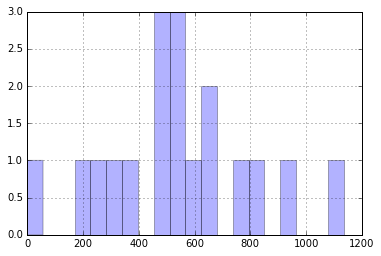

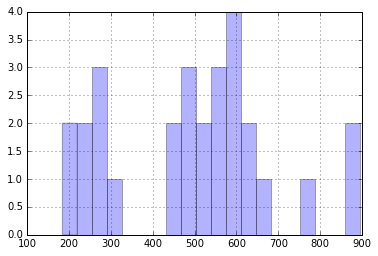

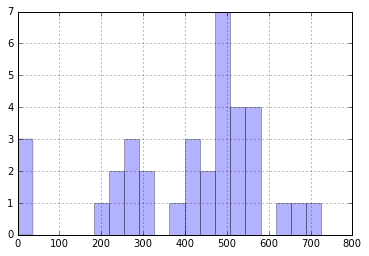

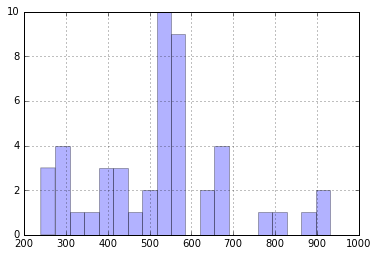

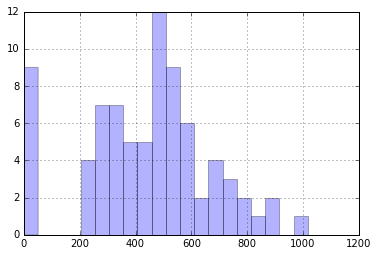

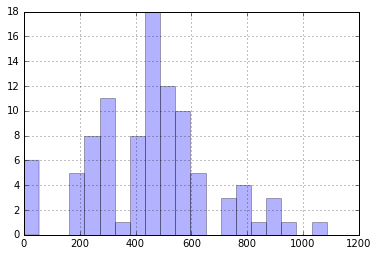

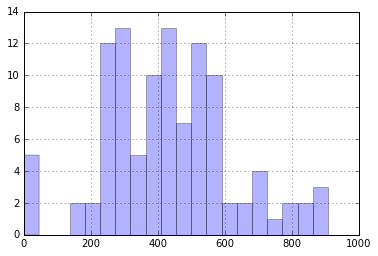

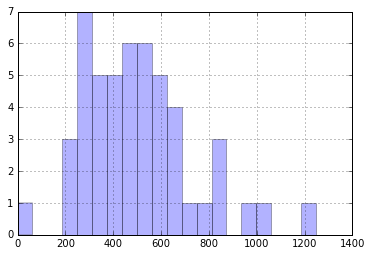

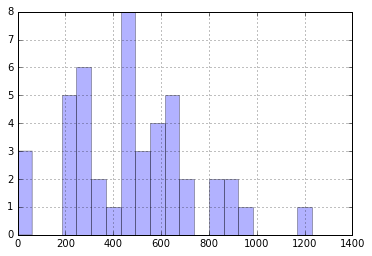

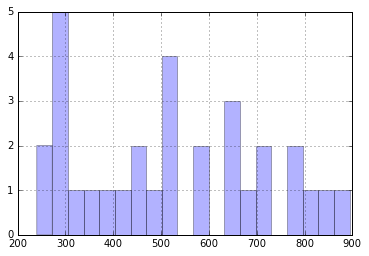

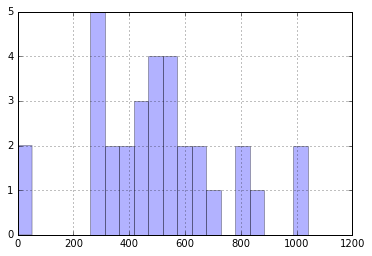

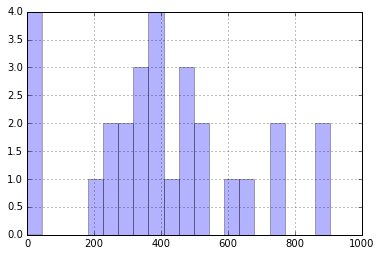

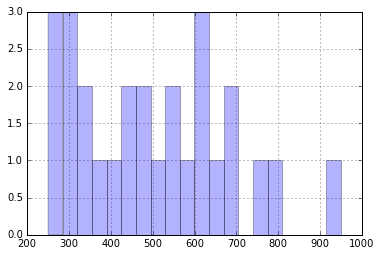

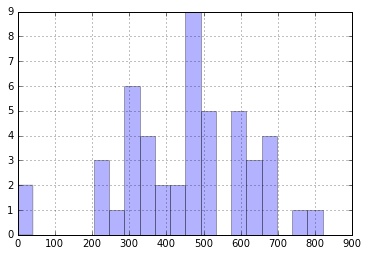

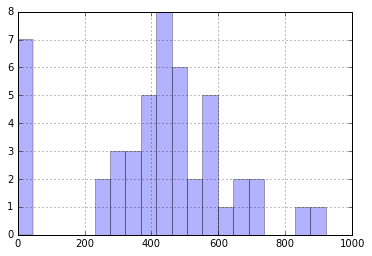

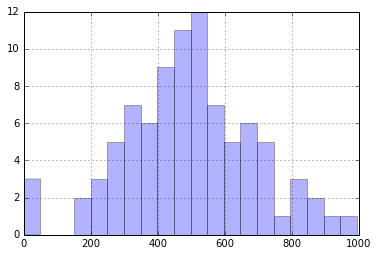

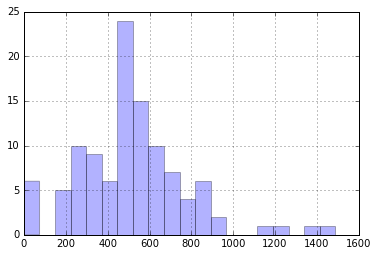

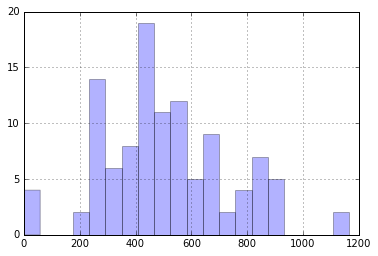

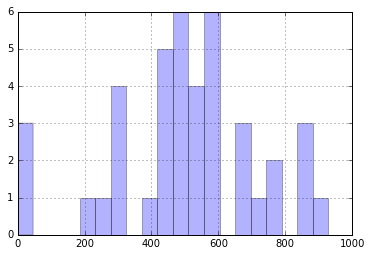

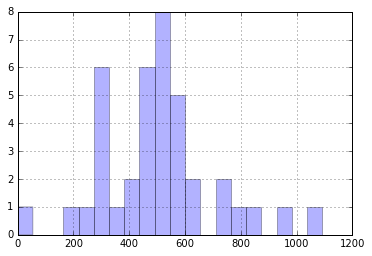

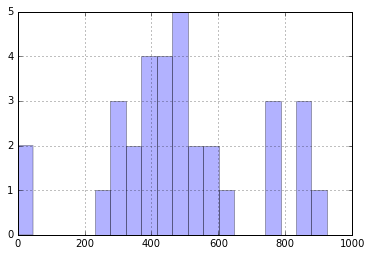

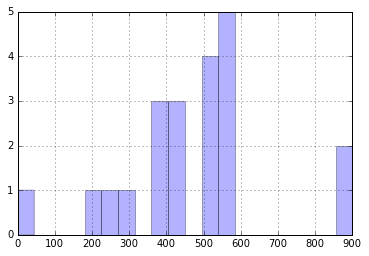

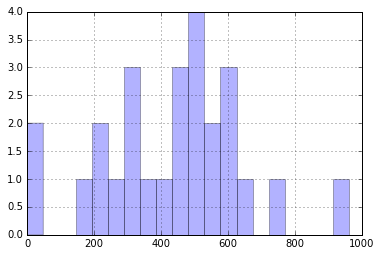

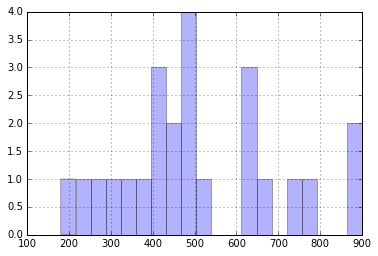

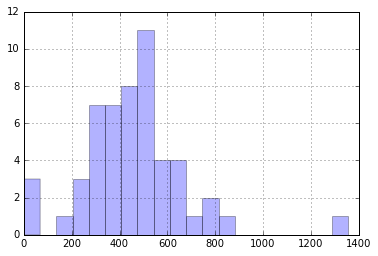

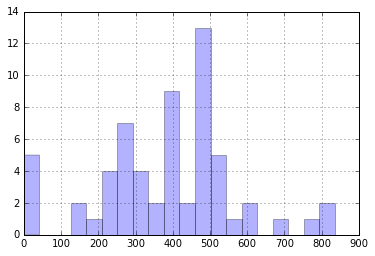

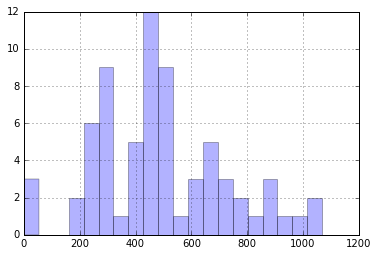

In [ ]:
toplot = df.merge(date_df, on = ['Yr Sold', 'Mo Sold'])
var = 'Garage Area'
for name, group in toplot.groupby(['date']):
    group[var].hist(bins = 20, alpha = 0.3)
    plt.show()

# Sesonality in the Data

From the first sight, we can observe clear seasonal pattern in *the number of sales/observation* we have in the dataset. The number of orders appears to peak at around summer every year. One hypothesis would be that houses would be settled at lower prices when the supply is high.

However, this sales seasonality does not seem to carry to *average sales prices*. The correlation between the number of sales and the average sales prices over this period is merely 0.19. One possible explanation would be that both supply and demand follow similar seasonal pattern, and thus does not have much influence on the settled prices.

Overall, we do not observe strong periodicity in average housing prices over this period. Considering the obvious link between the broad economic cycle and the housing market, we think this lack of seasonality in the data is more likely due to the limited history we have at hand.

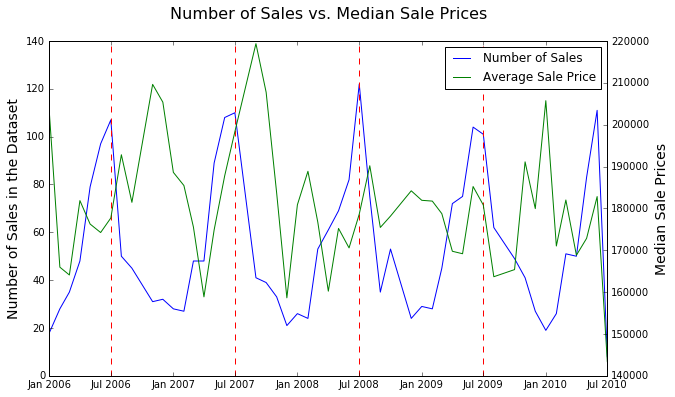

In [58]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
l1 = ax.plot(toplot.groupby('date').Order.count(), label = 'Number of Sales')#, legend = True)
ax2 = ax.twinx()
ax2.plot(toplot.groupby('date').SalePrice.mean(), c = 'g', label = 'Average Sale Price')
for date in dates[6:][::12]:
    ax.axvline(x=date, c = 'r', linestyle = '--')
ax.set_ylabel('Number of Sales in the Dataset', fontsize = 14)
ax2.set_ylabel('Median Sale Prices', fontsize = 14)
ax.set_title('Number of Sales vs. Median Sale Prices\n', fontsize = 16)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

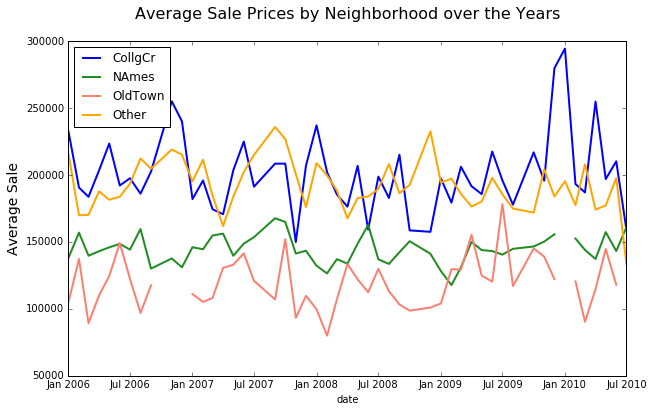

In [94]:
toplot.groupby(['date', 'Neighborhood_new']).SalePrice.mean().unstack('Neighborhood_new').plot(color=['blue', 'forestgreen', 
                                                                                                     'salmon', 'orange'],
                                                                                             figsize = (10, 6),
                                                                                             linewidth = 2)
plt.title('Average Sale Prices by Neighborhood over the Years\n', fontsize = 16)
plt.ylabel('Average Sale', fontsize = 14)
plt.legend(loc = 'upper left')

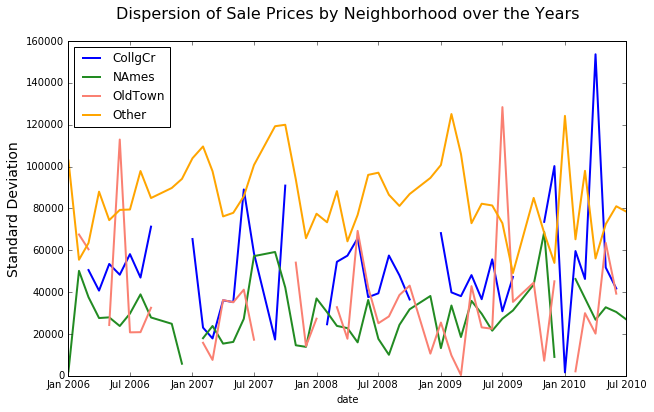

In [82]:
toplot.groupby(['date', 'Neighborhood_new']).SalePrice.std().unstack('Neighborhood_new').plot(color=['blue', 'forestgreen', 
                                                                                                     'salmon', 'orange'],
                                                                                             figsize = (10, 6),
                                                                                             linewidth = 2)
plt.title('Dispersion of Sale Prices by Neighborhood over the Years\n', fontsize = 16)
plt.ylabel('Standard Deviation', fontsize = 14)
plt.legend(loc = 'upper left')

In [226]:
y = df2.SalePrice_demean
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, random_state=42)

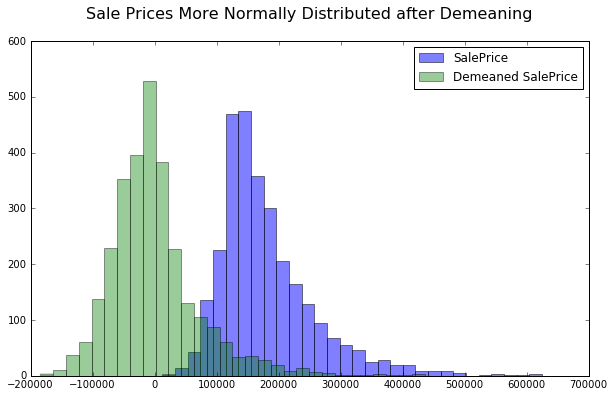

In [227]:
fig = plt.figure(figsize = (10, 6))
plt.hist(df.SalePrice, bins = 30, label='SalePrice', alpha = 0.5)
plt.hist(df.SalePrice_demean, bins = 30, label='Demeaned SalePrice', alpha = 0.4)
plt.legend()
plt.title('Sale Prices More Normally Distributed after Demeaning\n', fontsize = 16)

In [23]:
names = list(df2.columns.values)

In [24]:
#linear model without deleting features
x = df2.values[:,:-1]
y = df2.values[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
lr_scores = lr.score(x_test, y_test)
lr_scores

0.84297886090467045

In [25]:
cat_dic = {}
for cat_name in catergorical_col:
    for name in names:
         if cat_name in name:
                if cat_name not in cat_dic:
                    cat_dic[cat_name] = [name]
                else:
                    cat_dic[cat_name].append(name)

In [26]:
dropcols=[]
for col_name in names:
    x = df2[col_name]
    result = pd.ols(x=x,y=y)
    if result.p_value.x> 0.05:
        dropcols.append(col_name)
        print col_name, result.p_value

/Users/Heidi/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


Alley_Pave x            0.578714
intercept    0.927663
dtype: float64
Lot Shape_IR3 x            0.130546
intercept    0.916576
dtype: float64
Land Contour_Low x            0.639725
intercept    0.948297
dtype: float64
Utilities_NoSeWa x            0.428453
intercept    0.988304
dtype: float64
Utilities_NoSewr x            0.065021
intercept    0.961462
dtype: float64
Lot Config_Corner x            0.515759
intercept    0.786669
dtype: float64
Lot Config_FR2 x            0.221550
intercept    0.834713
dtype: float64
Lot Config_FR3 x            0.976442
intercept    0.998368
dtype: float64
Land Slope_Sev x            0.582997
intercept    0.971914
dtype: float64
Condition 1_RRAn x            0.357055
intercept    0.904034
dtype: float64
Condition 1_RRNe x            0.107072
intercept    0.941734
dtype: float64
Condition 1_RRNn x            0.583988
intercept    0.975739
dtype: float64
Condition 2_Artery x            0.053614
intercept    0.936305
dtype: float64
Condition 2_Norm x      

In [68]:
len(dropcols)

108

In [281]:
len(names)

322

In [27]:
df3 = df2.drop(dropcols, axis = 1)

In [28]:
df3.head()

,PID,MS SubClass,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Frontage,...,Sale Type_ConLD,Sale Type_ConLw,Sale Type_New,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Normal,Sale Condition_Partial,SalePrice_demean
0,526301100,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,141.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,69074.000000
1,526350040,20,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-57636.363636
2,526351010,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,81.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9363.636364
3,526353030,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,93.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,93988.333333
4,527402200,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.22459,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-5766.666667


In [29]:
#linear model after deleting unrelated columns
x = df3.values[:,:-1]
y = df3.values[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)
lr_scores = lr.score(x_test, y_test)
lr_scores

0.8028800868724737

In [71]:
df3.head()

,PID,MS SubClass,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Frontage,...,Sale Type_ConLD,Sale Type_ConLw,Sale Type_New,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Normal,Sale Condition_Partial,SalePrice_demean
0,526301100,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,141.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,69074.000000
1,526350040,20,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-57636.363636
2,526351010,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,81.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9363.636364
3,526353030,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,93.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,93988.333333
4,527402200,20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.22459,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-5766.666667


In [30]:
#cross validation to find the best regulization parameter
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.cross_validation import KFold
L_score = []
R_score = []
kf = KFold(n = len(x_train), n_folds=5)

regularization = 10.**np.arange(-10, 10)
for c in regularization:
    lasso_score = []
    ridge_score = []
    lasso_reg = Lasso_Reg(alpha = c)
    ridge_reg = Ridge_Reg(alpha = c)
    for train_index, test_index in kf:
        train_x, test_x = x_train[train_index], x_train[test_index]
        train_y, test_y = y_train[train_index], y_train[test_index]
        lasso_reg.fit(train_x, train_y)
        ridge_reg.fit(train_x, train_y)
        lasso_score.append(lasso_reg.score(test_x,test_y))
        ridge_score.append(ridge_reg.score(test_x,test_y))
    L_score.append(np.average(lasso_score))
    R_score.append(np.average(ridge_score))

/Users/Heidi/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [31]:
print L_score
print "\nThe max score happens at",regularization[L_score.index(max(L_score))],"with score of %s \n"%max(L_score)
print R_score
print "\nThe max score happens at",regularization[R_score.index(max(R_score))],"with score of", max(R_score)

[0.76119284496217554, 0.76119284503678608, 0.76119284578288882, 0.76119285324391195, 0.76119292785366177, 0.76119367390259107, 0.76120112953402963, 0.76127528061120808, 0.76201389202529979, 0.76359798653115918, 0.76585137266426817, 0.7784499830744912, 0.80263557825437248, 0.76960675479368346, 0.70620927987175097, 0.68998880608384527, 0.65624398859989186, 0.4652403801928392, 0.11247360818545864, 0.086936615527188038]

The max score happens at 100.0 with score of 0.802635578254 

[0.76339595674306815, 0.76339778242434941, 0.76339796005092064, 0.76339799400852792, 0.76339817249305608, 0.76339993787343052, 0.76341757196974636, 0.76359211258844062, 0.76518411694785893, 0.77418756237733277, 0.79068761488851247, 0.80200217151742303, 0.79467221662289489, 0.75159947024653329, 0.70837732370799322, 0.69870211771381319, 0.68773978335197028, 0.67452325689179105, 0.64253316809465133, 0.39988330612586082]

The max score happens at 10.0 with score of 0.802002171517


## We use the Lasso model as explored earlier

In [90]:
#lasso regression
lasso_reg = Lasso_Reg(alpha = 100)
lasso_reg.fit(x_train, y_train)
print lasso_reg.score(x_test,y_test)

 0.873273368464


In [40]:
from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
     max_depth=1, random_state=0, loss='ls').fit(x_train, y_train)
est.score(x_test, y_test)

0.626077783061739

In [32]:
#lasso regression
lasso_reg = Lasso_Reg(alpha = 10)
lasso_reg.fit(x_train, y_train)
print lasso_reg.score(x_test,y_test)
y_pred = lasso_reg.predict(x)
len(y_pred), len(x)

0.814731755703


(2918, 2918)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)   # Standard deviation of the difference
    

    plt.scatter(mean, diff, color = "darkred", *args, **kwargs)
    plt.axhline(md,           color='black', linestyle='--')
    plt.axhline(md + 1.96*sd, color='black', linestyle='--')
    plt.axhline(md - 1.96*sd, color='black', linestyle='--')
    #plt.xlim(-10,600000)
    plt.ylim(-150000,150000)

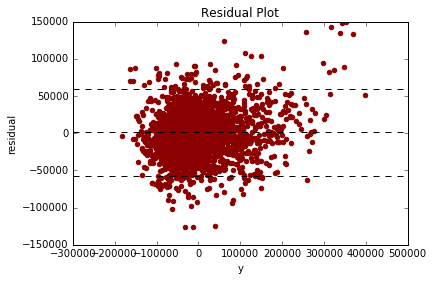

In [34]:
bland_altman_plot(y, y_pred)
plt.title('Residual Plot')
plt.ylabel("residual")
plt.xlabel("y")
plt.show()


# timeseries

In [35]:
## create dates from year and month
import datetime
yrs = range(2006, 2011)
months = range(1, 13)
dates = []
for y in yrs:
    for m in months:
        dates.append(datetime.date(y, m, 1))
dates = dates[:-5]

In [36]:
dfts = df.groupby(['Yr Sold', 'Mo Sold','Neighborhood_new']).SalePrice.mean().unstack().reset_index()
dfts2 = dfts.drop(['Yr Sold', 'Mo Sold'], axis = 1)
dfts2.index = dates
dfts2.index = pd.DatetimeIndex(dfts2.index)
dfts2 = dfts2.apply(lambda x: x.interpolate('linear'))
dfts2 = dfts2.fillna(method ='bfill')

In [37]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize = (8, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation - %s'%title)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

## check time series stationarity and parameter selection

Stationarity: Rolling averages and standard deviations of the diffs in neighborhood mean housing prices appear to be generally stable and do not show obvious divergence. Based on Dicky-Fuller test statistics, we can reject the null hypothesis that the time series of these differences are non-stationary for all neighborhoods except for NAmes. For NAmes, the test statistic falls between the 5% and 10% critical value, with a p-value of roughly 7%. Although it is not ideal, it is not very far from the typical 5% critical value cutoff we generally use. Since this part of the model serves illustration purpose, we will continue on to consider NAmes as an acceptable series.

Autocorrelation: The autocorrelation plots show the correlation between current housing price average with previous housing price averages at different lags by neighborhood. We can see that the autocorrelation is not very strong. OldTown and Others show some periodicity based on the autocorrelation plots, but not very strong. We will thus consider 1-period autocorrelation in the ARIMA model.

/Users/Heidi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/Heidi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


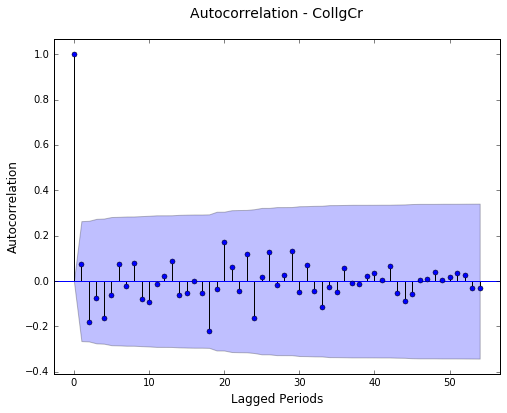

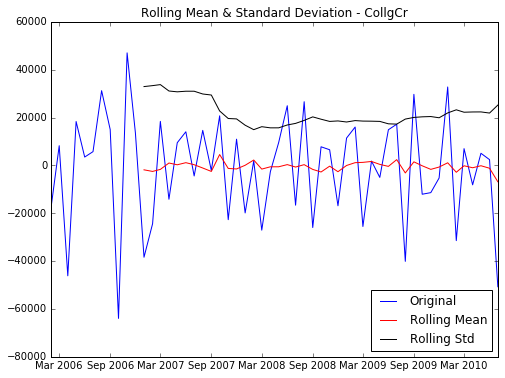

Results of Dickey-Fuller Test:
Test Statistic                -1.083332e+01
p-value                        1.686375e-19
#Lags Used                     0.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (5%)           -2.917850e+00
Critical Value (1%)           -3.560242e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


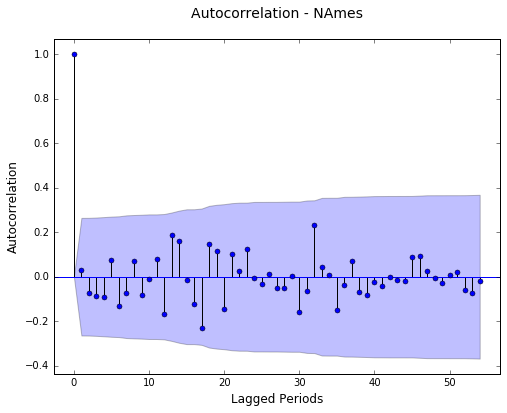

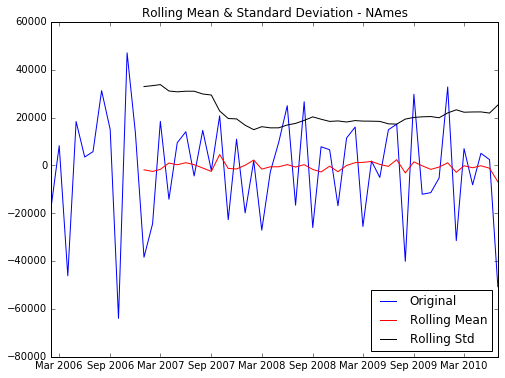

Results of Dickey-Fuller Test:
Test Statistic                -1.083332e+01
p-value                        1.686375e-19
#Lags Used                     0.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (5%)           -2.917850e+00
Critical Value (1%)           -3.560242e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


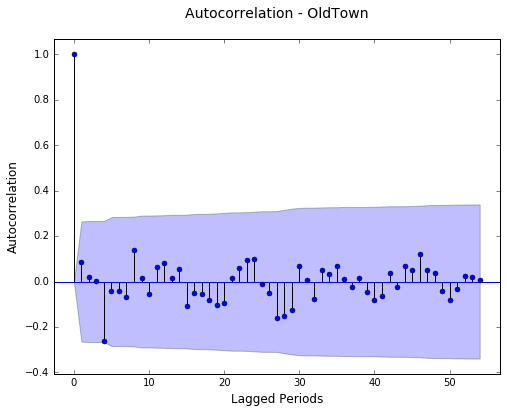

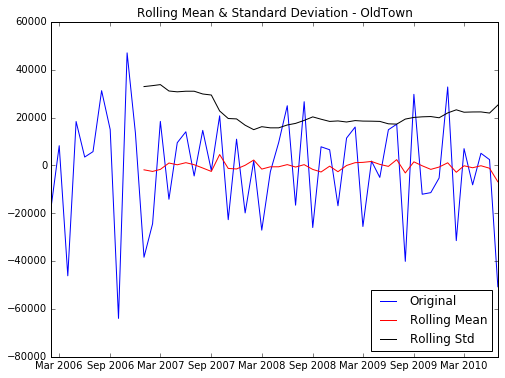

Results of Dickey-Fuller Test:
Test Statistic                -1.083332e+01
p-value                        1.686375e-19
#Lags Used                     0.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (5%)           -2.917850e+00
Critical Value (1%)           -3.560242e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


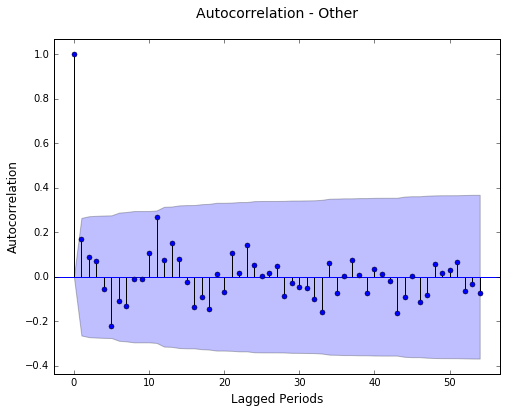

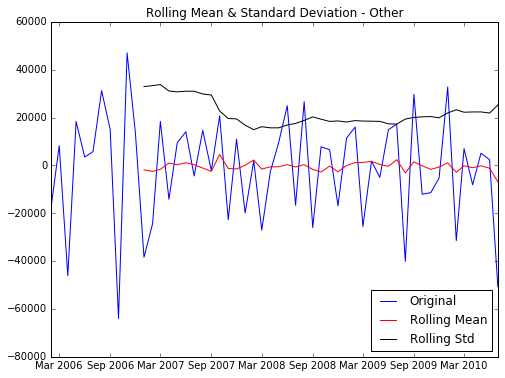

Results of Dickey-Fuller Test:
Test Statistic                -1.083332e+01
p-value                        1.686375e-19
#Lags Used                     0.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (5%)           -2.917850e+00
Critical Value (1%)           -3.560242e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


In [46]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
for col in dfts2.columns:
    ts_diff = dfts2[col] - dfts2[col].shift()
    #plt.plot(ts_log_diff)
    lag_acf = acf(ts_diff, nlags=10)
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_subplot(111)
    sm.graphics.tsa.plot_acf(dfts2[col], ax = ax)
    ax.set_title('Autocorrelation - %s\n'%col, fontsize = 14)
    ax.set_ylabel('Autocorrelation', fontsize = 12)
    ax.set_xlabel('Lagged Periods', fontsize = 12)
    #ts_log_diff.dropna(inplace=True)
    test_stationarity(ts_log_diff.dropna(), col)

## ARIMA Model 

The Auto-Regressive Integrated Moving Averages forecasting model for a stationary time series is a linear model where the predictors depend on the parameters related to the number of auto-regressive terms, moving average terms, and number of non-seasonal difference. It is usually applied where there's strong dependence among the observations in the time dimension. As we have described above, the time dependence is not very significant in this dataset. Therefore, we select short terms as parameters to be used (1 for the auto-regressive term, 1 for moving average term, and disregard the nonseasonal differences argument (in which case the model defaults to taking the first order differences to model).

The ARIMA model can be expressed as: $P_t = a* P_{t-1} + \epsilon_t + \theta * \epsilon_{t-1}$

### In-Sample Fits

In [65]:
## in-sample fit with ARIMA model
fits=dfts2.copy().ix[1:]
for col in dfts2.columns:
    fits[col+'_fitted'] = dfts2[col][:-1]+ARIMA(dfts2[col], order=(1, 1, 0)).fit(disp=-1).fittedvalues

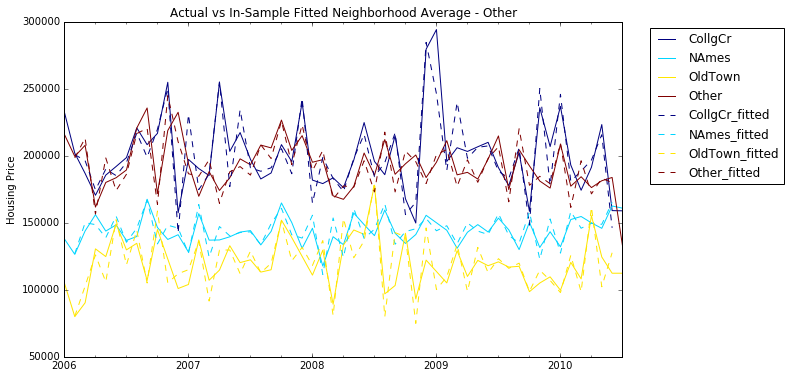

In [70]:
#df3.plot(colormap='jet')
cols = dfts2.columns
ax = dfts2[cols].plot(figsize = (10, 6), colormap='jet',linewidth=1)
fits[cols+'_fitted'].plot(ax = ax, colormap='jet', linestyle = '--')
ax.legend(bbox_to_anchor=(1.3, 1))
ax.set_title('Actual vs In-Sample Fitted Neighborhood Average - %s'%col)
ax.set_ylabel('Housing Price')

### ARIMA model rolling forward forecasting
When we fit the ARIMA model on the full dataset, we can see that the in-sample fits we obtain traces fairly closely the actual time series. However, in reality when we apply such a model, we would not have foresight into future trends, and we will have to extrapolate our model to make future forecasts.

To mimic this process and make the model more valuable in practice, we assume a rolling forward estimation situation. At every point in time, we assume that we have all previous information, fit the ARIMA model to forecast the difference between this period average and the next period (forward one month) average, and add that forecast to the current period observation to obtain an estimate. The formular is thus: $\hat{P_{t+1}} = P_t + \hat{\Delta(P)}_{t, t+1}$. 

Our predicted values are obtained by assuming the rolling estimation. For every predicted neighborhood average at a given time period, the model only considers the information before the time of interest. We can see from the actual vs. forecasted plots that the more realistic forecasts appear to be delayed (since we always built future forecasts based on previous information) and no longer follow the actual time series as closely as the in-sample fits.

In [50]:
## predict with ARIMA model
from statsmodels.tsa.arima_model import ARIMA
## we starting forecasting from the 10th period
preds=dfts2.copy().ix[10:]
for col in train.columns:
    preds_i = []
    for i in range(10, dfts2.shape[0]):
        model = ARIMA(dfts2[col][:i], order=(1, 1, 0)).fit(disp=-1)
        preds_i.append(dfts2[col][i-1]+model.predict(start=i, end = i).values[0])
    preds[col+'_pred'] = preds_i

/Users/Heidi/anaconda2/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


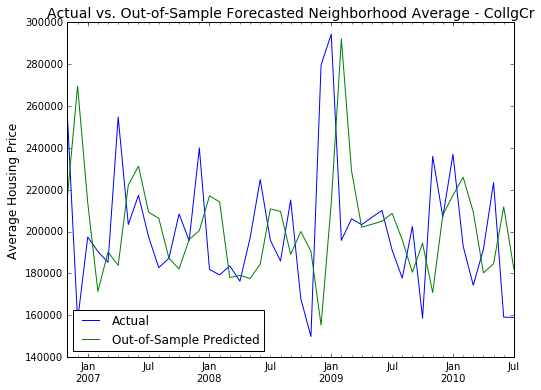

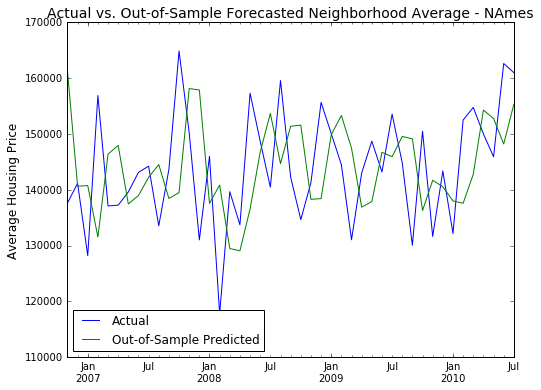

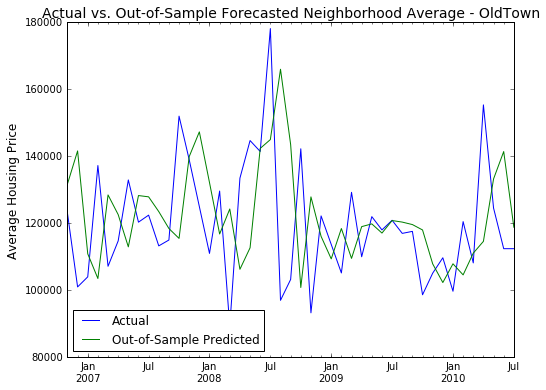

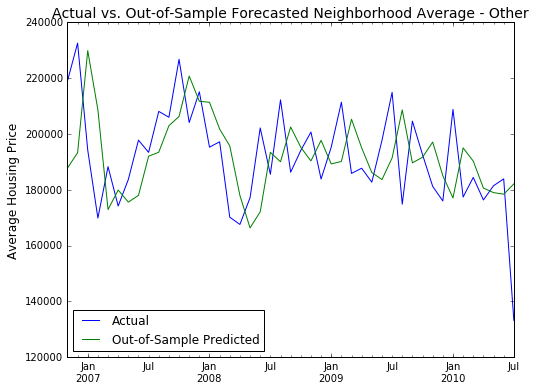

In [71]:
for col in test.columns:
    preds[col].plot(figsize = (8, 6), label = 'Actual')
    preds[col+'_pred'].plot(label = 'Out-of-Sample Predicted')
    plt.ylabel('Average Housing Price', fontsize = 12)
    plt.title('Actual vs. Out-of-Sample Forecasted Neighborhood Average - %s'%col, fontsize = 14)
    plt.legend(loc = 'lower left')
    plt.show()

***Finally, we combine the time series forecasts for neighborhood averages with the cross-sectional forecasts for every house's pricing deviation from its neighborhood average.***

In [74]:
predsdf = preds.select(lambda x: 'pred' in x, axis = 1).stack().reset_index()
predsdf.columns=['date', 'Neighborhood_new', 'SalePrice_PredAvg']

In [75]:
predsdf['Yr Sold'] = predsdf.date.map(lambda x: x.year)
predsdf['Mo Sold'] = predsdf.date.map(lambda x: x.month)

In [76]:
predsdf['Neighborhood_new'] = predsdf['Neighborhood_new'].map(lambda x: x[:-5])

In [77]:
finaldf = df.merge(predsdf, on =['Yr Sold', 'Mo Sold', 'Neighborhood_new'], how = 'left')

In [78]:
finaldf['SalePrice_PredDemean'] = y_pred

In [79]:
finaldf['SalePrice_Pred'] = finaldf.SalePrice_PredAvg + finaldf.SalePrice_PredDemean

In [80]:
finaldf = finaldf[finaldf.date>=dfts2.ix[10].name.date()]

In [81]:
def score(predicted, actual):
    rss = np.sum((predicted - actual)**2)
    tss = np.sum((actual - actual.mean())**2)
    rsq = 1 - rss/tss
    return rsq

In [85]:
print "Final combined model fitted r-squared is ", round(score(finaldf.SalePrice_Pred, finaldf.SalePrice), 2)

Final combined model fitted r-squared is  0.85


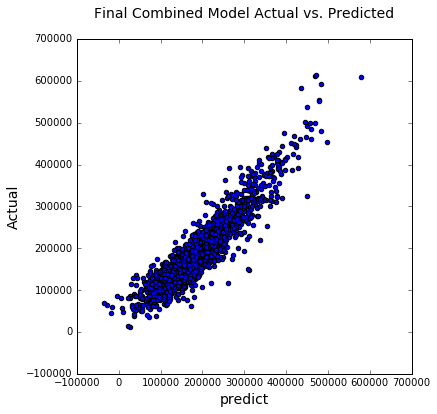

In [84]:
fig = plt.figure(figsize = (6, 6))
plt.scatter(finaldf.SalePrice_Pred, finaldf.SalePrice)
#plt.title('Combined Model Actual vs. Predicted\n', fontsize = 16)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('predict', fontsize= 14)
plt.title('Final Combined Model Actual vs. Predicted\n', fontsize = 14)